# Robótica Móvel - Trabalho Prático 3 (TP3)
# Occupancy Grid Mapping

---

**Nome Completo:** Daniel Terra Gomes  
**Matrícula:** 2025702870  
**Programa:** Mestrando do PPGCC  
**Departamento:** Departamento de Ciência da Computação  
**Instituição:** ICEx-UFMG  
**E-mail:** danielterragomes@ufmg.br  
**Data:** Novembro de 2025  

---

## Objetivo

Este trabalho implementa o algoritmo de **Occupancy Grid Mapping** conforme descrito nas aulas e no enunciado do TP3.

### Componentes Principais:

1. **Robô Kobuki**: Robô diferencial equipado com sensor laser Hokuyo
2. **Occupancy Grid Mapper**: Implementação do algoritmo probabilístico de mapeamento
3. **Exploration Planner**: Estratégia simples de navegação reativa
4. **Sensor Noise**: Ruído Gaussiano adicionado às leituras do laser

### Experimentos:

- **Teste 1**: Avaliação de 3 tamanhos de célula (0.01, 0.1, 0.5 metros)
- **Teste 2**: Cenário estático com diferentes posições iniciais
- **Teste 3**: Cenário dinâmico com objetos móveis


---

## Imports, Initial Config

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from copy import deepcopy
from typing import List, Tuple

from utils.visualization_utils import plot_combined_visualization
from utils.tp3_utils import (transform_laser_to_global)
from utils.wall_follower import WallFollower
from utils.kobuki_controller import KobukiController
from utils.occupancy_grid_mapper import OccupancyGridMapper
from utils.debug_logger import (log_data,log_section_header)
# Configure matplotlib for better visualization
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100

# Configuration
DEBUG_MODE = False  # Set to False to disable debug logging

print("\nMake sure CoppeliaSim is running with:")
print("  - cena-tp3-estatico.ttt OR")
print("  - cena-tp3-dinamico.ttt")


Make sure CoppeliaSim is running with:
  - cena-tp3-estatico.ttt OR
  - cena-tp3-dinamico.ttt


## Simulation Loop init

This is the core of TP3: run a complete simulation loop to build the occupancy grid.



In [38]:
# Scene selection
SCENE_TYPE = "dynamic"  # Options: "static" or "dynamic" - just for plot
CELL_SIZE = 0.61  # Cell size in meters (test with 0.01, 0.1, 0.5)

# Simulation parameters
SIMULATION_DURATION = 60.0  # seconds
DT = 0.05  # simulation time step (50ms)

# Sensor noise parameters
DISTANCE_NOISE_STD = 0.02  # 2 cm standard deviation
ANGLE_NOISE_STD = 0.005  # ~0.3 degrees standard deviation

# Map parameters
MAP_SIZE = (15, 15)  # meters (15m x 15m map)

# If D_SAFE >= d_follow, robot will turn away before reaching following distance
V_NOMINAL = 0.40  # nominal linear velocity (m/s)
D_SAFE = 0.5     # safe distance threshold (m) - MUST be < d_follow (0.6m)
D_FOLLOW = 0.6    # target wall-following distance (m)

MAP_ORIGIN = (-5.0, -5.0)  # Bottom-left corner: -5m in X and Y
MAP_SIZE_M = (10.0, 10.0)  # 10m x 10m coverage (centered around origin)
CELL_RES = CELL_SIZE       # Use the cell size from configuration
MAX_VALID_RANGE = 4.9  # meters


controller = KobukiController(robot_name='kobuki')
mapper = OccupancyGridMapper(
    origin=MAP_ORIGIN,      # REQUIRED: Grid bottom-left corner
    map_size=MAP_SIZE_M,    # Grid dimensions in meters
    cell_size=CELL_RES      # Cell resolution
)

planner = WallFollower(
    v_nominal=V_NOMINAL,
    w_max=np.deg2rad(45),  # 45 degrees/second max turn rate
    d_safe=D_SAFE,          # Safety distance (must be < d_follow!)
    d_follow=D_FOLLOW       # Target distance to maintain from right wall
)

if not controller.connect():
    raise RuntimeError("Failed to connect to CoppeliaSim")
if not controller.initialize_scene():
    raise RuntimeError("Failed to initialize scene")

robot_trajectory = []  # List of (x, y, theta) tuples
all_laser_points = []  # List of all laser points in global frame
velocity_history = []  # List of (v, w) tuples
time.sleep(1)

Kobuki Controller initialized for robot: kobuki
  Wheelbase (L): 0.23 m
  Wheel radius (r): 0.035 m
    OccupancyGridMapper Initialized
Map Size (m):      10.0 x 10.0
Cell Size (m):     0.61
Grid Size (cells): 17 x 17
Total Cells:       289
Origin (m):        (-5.00, -5.00)
X-Range (m):       [-5.00, 5.00]
Y-Range (m):       [-5.00, 5.00]
Log-Odds:          Occ=2.197, Free=-2.197, Prior=0.0
Hit Radius (m):    0.1
[OK] Connected to CoppeliaSim[OK] Connected to CoppeliaSim
[OK] Found robot: kobuki (handle: 158)
[OK] Found motors: kobuki_leftMotor, kobuki_rightMotor
[OK] Initialized Hokuyo sensor: /kobuki/fastHokuyo
     Using buffer signal API for angle/range data
[OK] Initialized Hokuyo laser sensor via direct vision sensor reading
[OK] Laser-to-Robot transform acquired for offset correction:
    Position offset: [0.0000, 0.0000, 0.0720]
    Orientation: [-0.0000, 0.0000, -0.0000]

[OK] Found robot: kobuki (handle: 158)
[OK] Found motors: kobuki_leftMotor, kobuki_rightMotor
[OK] Initial

In [39]:
try:
    # Start simulation
    controller.sim.startSimulation()
    time.sleep(1)
    print("Simulation started!")

    start_time = time.time()
    iteration = 0
    last_snapshot_time = 0

    while (time.time() - start_time) < SIMULATION_DURATION:
        # 1. Get robot pose
        robot_pose = controller.get_pose()
        x, y, theta = controller.get_pose_2d()
        robot_trajectory.append((x, y, theta))

        # 2. Get laser data (RAW, without noise)
        laser_data = controller.get_laser_data()
        if laser_data is None:
            print("Warning: No laser data, skipping iteration")
            time.sleep(DT)
            continue

        # 3. === FILTER MAX-RANGE READINGS FIRST ===
        valid_mask = laser_data[:, 1] < MAX_VALID_RANGE
        laser_data_filtered = laser_data[valid_mask].copy()

        # 4. === ADD NOISE AFTER FILTERING ===
        laser_data_filtered[:, 0] += np.random.normal(0, ANGLE_NOISE_STD, len(laser_data_filtered))
        laser_data_filtered[:, 1] += np.random.normal(0, DISTANCE_NOISE_STD, len(laser_data_filtered))
        laser_data_filtered[:, 1] = np.clip(laser_data_filtered[:, 1], 0.01, MAX_VALID_RANGE - 0.01)

        # 5. Transform to global frame (ONLY VALID DETECTIONS)
        laser_transform = getattr(controller, 'laser_to_robot_transform', None)
        laser_points_global = transform_laser_to_global(
            robot_pose, laser_data_filtered, laser_to_robot_transform=laser_transform
        )
        all_laser_points.extend(laser_points_global.tolist())

        # 6. Update occupancy grid (ONLY VALID DETECTIONS)
        mapper.update_map(robot_pose, laser_points_global)

        # 7. Plan next velocities using wall-following
        v, w = planner.plan_step(laser_data)
        velocity_history.append((v, w))

        # 8. Send velocities to robot
        controller.set_velocity(v, w)

        # 9. Step simulation
        controller.sim.step()

        elapsed = time.time() - start_time

        # Progress indicator
        iteration += 1
        if iteration % 100 == 0:
            elapsed = time.time() - start_time
            print(f"[{elapsed:.1f}s] Iteration {iteration}, Valid points: {len(laser_data_filtered)}/{len(laser_data)}")

except Exception as e:
    print(f"Error in simulation: {e}")
    import traceback
    traceback.print_exc()
finally:
    # Always stop the robot and simulation
    controller.set_velocity(0, 0)
    controller.sim.stopSimulation()
    time.sleep(1)
    print("Simulation stopped!")

# Print final statistics
elapsed = time.time() - start_time
print("SIMULATION COMPLETE")
final_stats = {
    "Duration": f"{elapsed:.2f}s",
    "Iterations": iteration,
    "Trajectory Points": len(robot_trajectory),
    "Laser Points Collected": len(all_laser_points),
    "Grid Size": f"{mapper.grid_map.shape}",
    "Cell Size": f"{CELL_SIZE}m"
}
for key, value in final_stats.items():
    print(f"{key:.<30} {value}")

Simulation started!

[WallFollower] Laser data verification:
  Shape: (684, 2)
  First 3 readings: [[-1.57079637  4.9994998 ]
 [-1.56785512  4.9994998 ]
 [-1.5648967   4.9994998 ]]
  Angle range: [-90.0°, 90.0°]
  Distance range: [0.607m, 4.999m]
  Expected: 684 beams covering -90° to +90°


[COLLISION WARNING #1] Distance 0.238m < critical 0.25m
  d_right=0.238m, d_front=0.979m, d_left=1.345m
  [EMERGENCY STOP] Stopped. Stuck counter: 1/40

[COLLISION WARNING #1] Distance 0.238m < critical 0.25m
  d_right=0.238m, d_front=0.979m, d_left=1.345m
  [EMERGENCY STOP] Stopped. Stuck counter: 1/40

[COLLISION WARNING #11] Distance 0.236m < critical 0.25m
  d_right=0.236m, d_front=0.991m, d_left=1.354m
  [EMERGENCY STOP] Stopped. Stuck counter: 11/40

[COLLISION WARNING #11] Distance 0.236m < critical 0.25m
  d_right=0.236m, d_front=0.991m, d_left=1.354m
  [EMERGENCY STOP] Stopped. Stuck counter: 11/40

[COLLISION WARNING #21] Distance 0.236m < critical 0.25m
  d_right=0.236m, d_front=0.992m, 

# Occupancy Grid

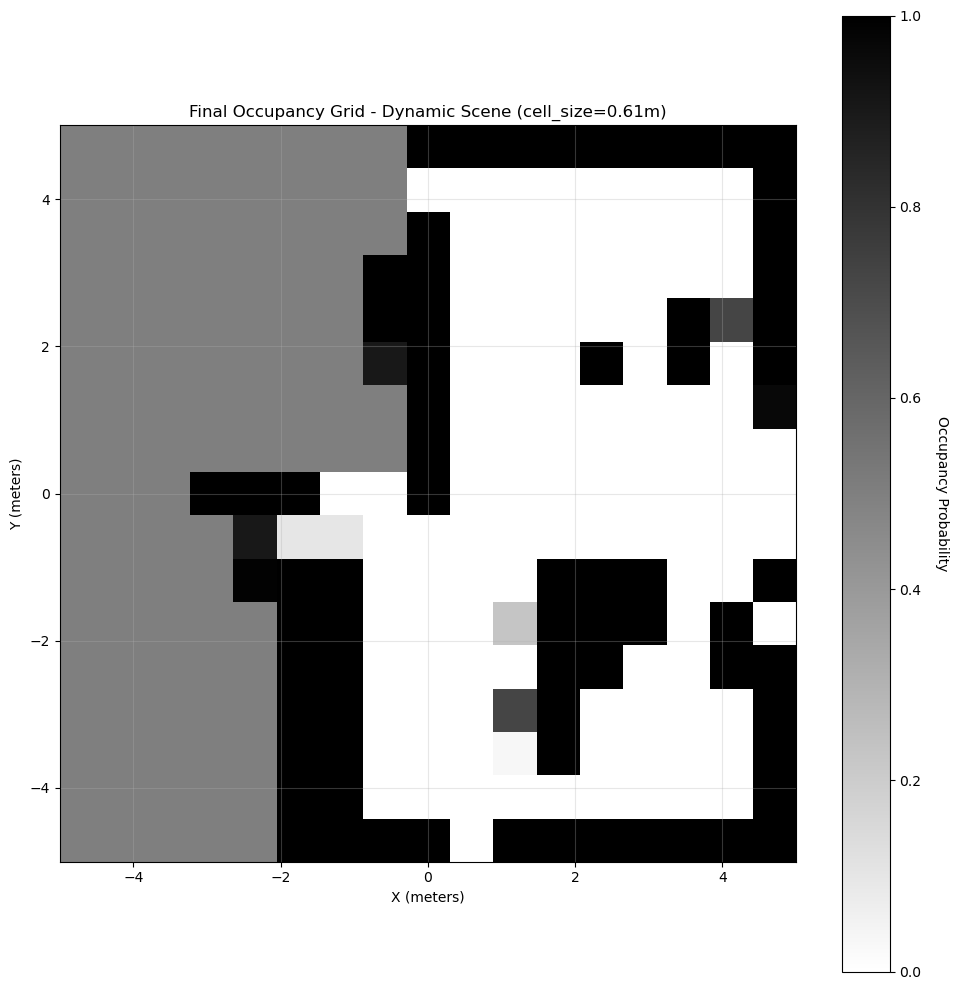

   Occupancy grid map saved: occupancy_grid_dynamic_cell0.61.png
   Resolution: 17 x 17 cells
   Coverage: [-5.0, 5.0] x [-5.0, 5.0] m
Map saved to: occupancy_grid_dynamic_cell0.61.png


In [40]:
# Visualize final occupancy grid
mapper.visualize_map(title=f"Final Occupancy Grid - {SCENE_TYPE.capitalize()} Scene (cell_size={CELL_SIZE}m)")

# Save map image
filename = f"occupancy_grid_{SCENE_TYPE}_cell{CELL_SIZE}.png"
mapper.save_map_image(filename)
print(f"Map saved to: {filename}")


Combined visualization saved to: combined_result_dynamic_cell0.61.png
Grid world coordinates: X=[-5.0, 5.0], Y=[-5.0, 5.0]
Trajectory points: 658
Laser points: 379812 (displayed: 75963 downsampled)


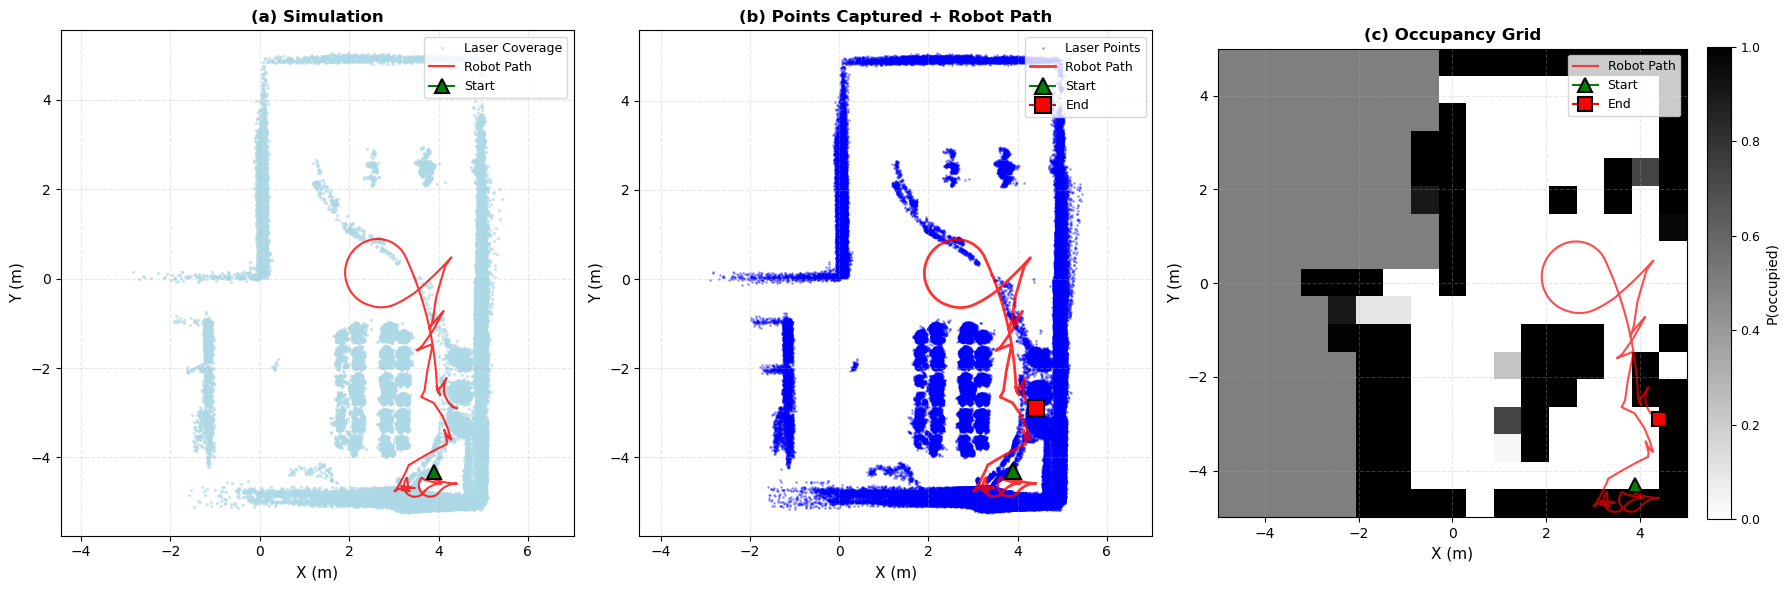

In [41]:
# Create combined visualization following TP3 requirements
# This generates the 3-panel figure: (a) Simulation, (b) Incremental Plot, (c) Occupancy Grid
plot_combined_visualization(
    trajectory=robot_trajectory,
    laser_points=all_laser_points,
    mapper=mapper,
    scene_type=SCENE_TYPE,
    cell_size=CELL_SIZE,
    save_path=f"combined_result_{SCENE_TYPE}_cell{CELL_SIZE}.png",
    show_plot=True,
   # downsample_laser=5  # Downsample for cleaner visualization
)